# Regressão Softmax com dados do MNIST utilizando gradiente descendente estocástico por minibatches

O objetivo deste notebook é ilustrar
- o uso do gradiente estocástico por mini-batchs
- utilizando as classes Dataset e DataLoater.

A apresentação da perda nos gráficos é um pouco diferente da usual, mostrando a perda de cada um dos vários minibatches dentro de cada época, de forma que as épocas são apresentadas com valores fracionários.

## Importação das bibliotecas

In [4]:
# http://pytorch.org/
from os.path import exists
!pip install numpy==1.15.0
#!pip install -q install wheel==0.34.2 setuptools
import torch
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
print(get_abbr_impl())
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#https://download.pytorch.org/whl/cpu/torch-0.4.1.post2-cp37-cp37m-linux_x86_64.whl
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1.post2-{platform}-linux_x86_64.whl torchvision==0.2.1
import torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 46.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for numpy
  Running setup.py clean for numpy
  error: subprocess-exited-with-error
  
  × python setup.py clean did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed cleaning build dir for numpy
Failed to build numpy
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (numpy)


ModuleNotFoundError: No module named 'wheel.pep425tags'

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import MNIST

## Dataset e dataloader

### Definição do tamanho do minibatch

In [6]:
batch_size = 100

### Carregamento, criação dataset e do dataloader

In [7]:
! git clone https://github.com/vcasadei/MNIST.git

Cloning into 'MNIST'...
remote: Enumerating objects: 10, done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 10 (from 1)
Receiving objects: 100% (10/10), 11.01 MiB | 19.68 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [9]:
dataset_dir = 'MNIST/'

dataset_train = MNIST(dataset_dir, train=True, download=True,
                      transform=torchvision.transforms.ToTensor())

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

print('Número de minibatches de trenamento:', len(loader_train))

x_train, y_train = next(iter(loader_train))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

100%|██████████| 9.91M/9.91M [00:00<00:00, 38.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.05MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.43MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.5MB/s]

Número de minibatches de trenamento: 600

Dimensões dos dados de um minibatch: torch.Size([100, 1, 28, 28])
Valores mínimo e máximo dos pixels:  tensor(0.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


### Usando apenas 1000 amostras do MNIST

Neste exemplo utilizaremos 1000 amostras de treinamento.

In [10]:
if False:
    n_samples_train = 1000

    dataset_train.train_data = dataset_train.train_data[:n_samples_train]
    dataset_train.train_labels = dataset_train.train_labels[:n_samples_train]

print('Número de minibatches de trenamento:', len(loader_train))
n_batches_train = len(loader_train)
total_samples = dataset_train.train_data.size(0)

Número de minibatches de trenamento: 600


/usr/local/lib/python3.12/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


## Modelo

In [11]:
model = torch.nn.Linear(28*28, 10)


In [12]:
x = torch.ones(28*28).reshape(1, 784)
print(x.shape)
predict = model(x)
predict

torch.Size([1, 784])


tensor([[ 1.4612, -1.3359,  0.5669, -0.3178,  0.6505, -0.6490, -0.0074, -0.1819,
          0.2974,  0.3193]], grad_fn=<AddmmBackward0>)

## Treinamento

### Inicialização dos parâmetros

In [13]:
n_epochs = 50
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Laço de treinamento dos parâmetros

In [21]:
epochs = []
losses = []

total_trained_samples = 0
for i in range(n_epochs):
    for k,(x_train, y_train) in enumerate(loader_train):
        # Transforma a entrada para uma dimensão
        inputs = Variable(x_train.view(-1, 28 * 28))
        # predict da rede
        outputs = model(inputs)

        total_batches = len(loader_train)

        # calcula a perda
        loss = criterion(outputs, Variable(y_train))

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / total_samples)
        #losses.append(loss.data[0])
        losses.append(loss.item())
        #print(k)

    print(f"Época: {i+1}/{n_epochs}, batch: {k+1}/{total_batches}")

    print(f'Época: {i}/{n_epochs-1} minibatch: {k}')#.format(i,n_epochs-1))#, end='\r')

Época: 1/50, batch: 600/600
Época: 0/49 minibatch: 599
Época: 2/50, batch: 600/600
Época: 1/49 minibatch: 599
Época: 3/50, batch: 600/600
Época: 2/49 minibatch: 599
Época: 4/50, batch: 600/600
Época: 3/49 minibatch: 599
Época: 5/50, batch: 600/600
Época: 4/49 minibatch: 599
Época: 6/50, batch: 600/600
Época: 5/49 minibatch: 599
Época: 7/50, batch: 600/600
Época: 6/49 minibatch: 599
Época: 8/50, batch: 600/600
Época: 7/49 minibatch: 599
Época: 9/50, batch: 600/600
Época: 8/49 minibatch: 599
Época: 10/50, batch: 600/600
Época: 9/49 minibatch: 599
Época: 11/50, batch: 600/600
Época: 10/49 minibatch: 599
Época: 12/50, batch: 600/600
Época: 11/49 minibatch: 599
Época: 13/50, batch: 600/600
Época: 12/49 minibatch: 599
Época: 14/50, batch: 600/600
Época: 13/49 minibatch: 599
Época: 15/50, batch: 600/600
Época: 14/49 minibatch: 599
Época: 16/50, batch: 600/600
Época: 15/49 minibatch: 599
Época: 17/50, batch: 600/600
Época: 16/49 minibatch: 599
Época: 18/50, batch: 600/600
Época: 17/49 minibatc

A saída de streaming foi truncada nas últimas 5000 linhas.
Época: 3/3, batch: 1114/1875
Época: 3/3, batch: 1115/1875
Época: 3/3, batch: 1116/1875
Época: 3/3, batch: 1117/1875
Época: 3/3, batch: 1118/1875
Época: 3/3, batch: 1119/1875
Época: 3/3, batch: 1120/1875
Época: 3/3, batch: 1121/1875
Época: 3/3, batch: 1122/1875
Época: 3/3, batch: 1123/1875
Época: 3/3, batch: 1124/1875
Época: 3/3, batch: 1125/1875
Época: 3/3, batch: 1126/1875
Época: 3/3, batch: 1127/1875
Época: 3/3, batch: 1128/1875
Época: 3/3, batch: 1129/1875
Época: 3/3, batch: 1130/1875
Época: 3/3, batch: 1131/1875
Época: 3/3, batch: 1132/1875
Época: 3/3, batch: 1133/1875
Época: 3/3, batch: 1134/1875
Época: 3/3, batch: 1135/1875
Época: 3/3, batch: 1136/1875
Época: 3/3, batch: 1137/1875
Época: 3/3, batch: 1138/1875
Época: 3/3, batch: 1139/1875
Época: 3/3, batch: 1140/1875
Época: 3/3, batch: 1141/1875
Época: 3/3, batch: 1142/1875
Época: 3/3, batch: 1143/1875
Época: 3/3, batch: 1144/1875
Época: 3/3, batch: 1145/1875
Época: 3/3, b

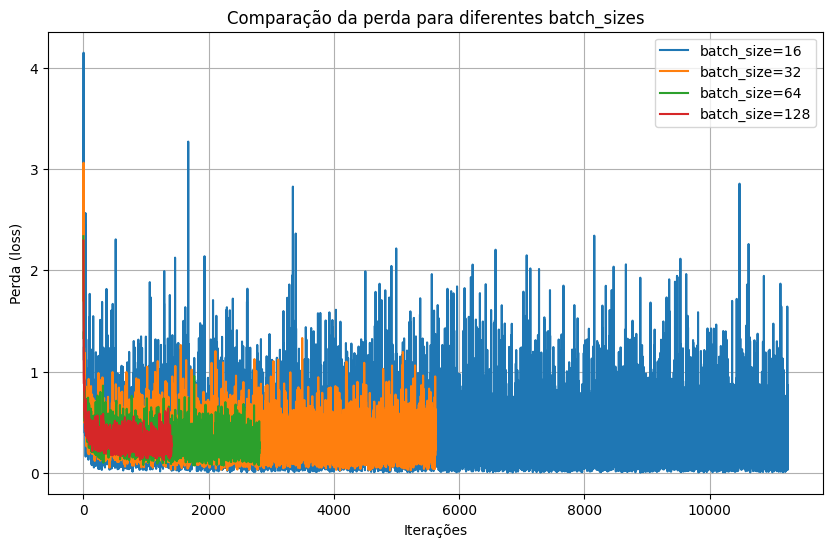

In [22]:
import torch
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms


# CONFIGURAÇÕES

learningRate = 0.5
n_epochs = 3
batch_sizes = [16, 32, 64, 128]

dataset_dir = "MNIST/"

dataset_train = MNIST(
    root=dataset_dir,
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

criterion = torch.nn.CrossEntropyLoss()

history = {}      # onde vamos salvar a perda de cada batch_size

# TREINAMENTO PARA CADA BATCH_SIZE

for bs in batch_sizes:

    print(f"Treinando com batch_size = {bs}")
    loader_train = DataLoader(dataset_train, batch_size=bs, shuffle=True)
    model = torch.nn.Linear(28*28, 10)
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

    total_samples = len(dataset_train)
    total_batches = len(loader_train)

    epochs_list = []
    losses_list = []
    total_trained_samples = 0

    for i in range(n_epochs):
        for k, (x_train, y_train) in enumerate(loader_train):

            # reshape
            inputs = Variable(x_train.view(-1, 28 * 28))
            outputs = model(inputs)
            loss = criterion(outputs, y_train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # registra perda
            total_trained_samples += x_train.size(0)
            epochs_list.append(total_trained_samples / total_samples)
            losses_list.append(loss.item())

            # print do minibatch
            print(f"Época: {i+1}/{n_epochs}, batch: {k+1}/{total_batches}")

        print(f"Fim da época {i+1}/{n_epochs}")

    history[bs] = losses_list    # salva a curva de perdas


# GRÁFICO FINAL DE COMPARAÇÃO

plt.figure(figsize=(10, 6))

for bs in batch_sizes:
    plt.plot(history[bs], label=f"batch_size={bs}")

plt.xlabel("Iterações")
plt.ylabel("Perda (loss)")
plt.title("Comparação da perda para diferentes batch_sizes")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
print('Final loss:', loss.item())

Final loss: 0.27647140622138977


### Visualizando gráfico de perda durante o treinamento

Text(0.5, 0, 'época')

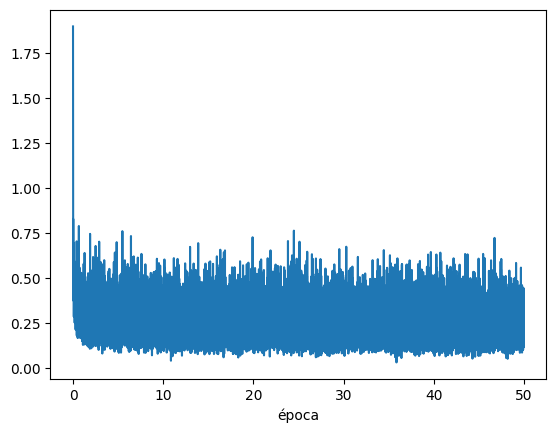

In [18]:
plt.plot(epochs, losses)
plt.xlabel('época')

### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

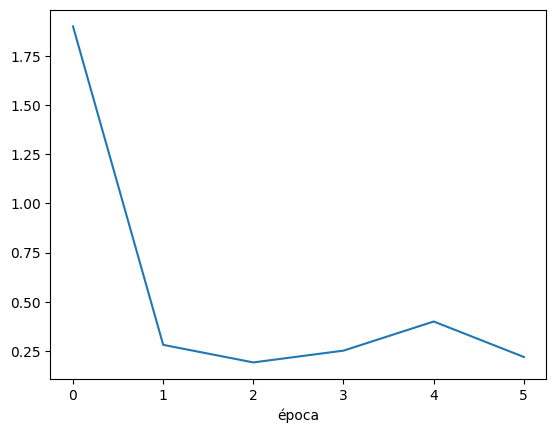

In [19]:
plt.plot(epochs[:5 * n_batches_train +1:n_batches_train], losses[:5 * n_batches_train+1:n_batches_train])
plt.xlabel('época')

# Atividades

## Perguntas

1. Qual é o tamanho do mini-batch?

-> 100 Imagens

2. Em uma época, quantos mini-batches existem?

-> MNIS de treino possui 660.000 imagens, com batch de 100 então
-> 60.000/100 = 600 mini-batches por época

3. Qual é a definição de época?

-> época em Deep Learning é uma passagem completa por todo o dataset de treino , no caso temos 60.000 imagens, e cada mini-batch contém 100, uma época irá determinar quando todas as 60.000 imagens passaram pela rede exatamente uma vez.

## Exercícios


1. Coloque um print no final de cada minibatch, no mesmo estilo do print do final de época, no seguinte estilo:
    - Época: 1/4, batch: 3/10
-> inserido no Loop acima.

2. Altere o tamanho de minibatch (batch_size) algumas vezes, refaça o treinamento, e compare no gráfico abaixo a queda da perda para cada tamanho de minibatch.
-> Inseri um outro código abaixo para validação do contexto desse teste

## Conclusões sobre os experimentos deste notebook


1. O mini-batch contribui com a rapidez da convergência, num mesmo número de épocas

-> Sem dúvidas, foi bem mais rápido, o mini-batch contribuiu de forma direta e mais rápida na convergência, mesmo mentando o mesmo número de épocas.


2. Os resultado pode ser mais ruidoso

-> Pode sim, pois os mini-batches menores tendem a ser mais rudiosos, isso é um comportamento esperado e desejado nos casos.
